In [1]:
# Matt Drury & Moses Marsh

import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from sklearn.datasets import load_iris, fetch_olivetti_faces
from sklearn.decomposition import PCA, TruncatedSVD
from pandas.tools.plotting import scatter_matrix

# Always make it pretty.
plt.style.use('ggplot')

%matplotlib inline

# Dimensionality Reduction

### Morning: Principal Component Analysis
- Why reduce dimensionality?
- What are "principal components"?
- How is PCA used to reduce dimensionality?


### Afternoon: PCA using the Singular Value Decomposition
- What is it and how is it used for PCA?
- How do you interpret the $U, \Sigma, V$ matrices?
- What are "latent features"?



# What is the dimensionality of this data set?


In [2]:
names= ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model', 'origin', 'car_name']
cars = pd.read_csv('data/cars.tsv', delim_whitespace=True, header=None, names=names)
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# What is the dimensionality of this data set?
MNIST handwritten digits. Each grayscale image is 28x28
<img src="images/mnist.png" style="width: 500px;" />

Each pixel is a feature, so each image (data point) is a 784-dimensional feature vector.

## Why Reduce Dimensions?
- Combat the **Curse of Dimensionality**
    - Remember how that ruined kNN and clustering?
- Facilitate **Visualization**
    - Most people only want to see 2 or 3 dimensions at a time
- Combine many raw features into a few meaningful latent features
    - More about this in the afternoon
- Compress your data
    - If you can represent your data in fewer dimensions without losing much information, you have saved some hard drive space.

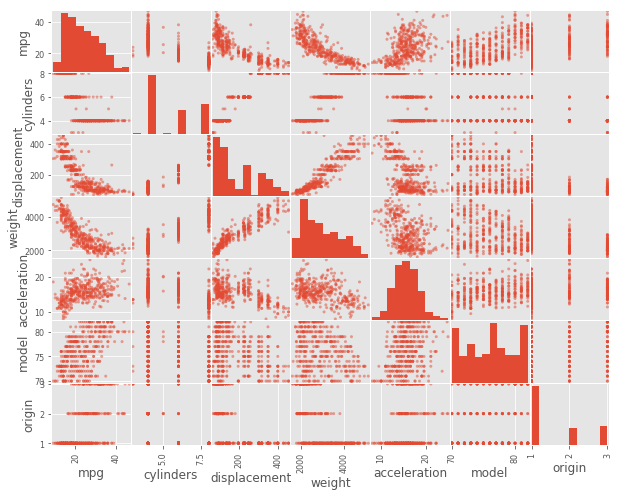

In [3]:
pd.plotting.scatter_matrix(cars, figsize=(10,8));

## Some methods for dimensionality reduction
- Subset selection of features; e.g. forward stepwise selection
- LASSO regression
- Relaxed LASSO:
    - (1) do LASSO regression, (2) throw away unused features, (3) do OLS regression
- Neural networks:
    - (black box)
- **Principal Components Analysis (PCA)**
    - In short: find the directions in feature space that account for the most variance in the data


### Introduction to Principal Component Analysis

Let's think of our data $X$ as a point cloud in $p$-dimensional space, and ask the following question:

**Fundamental Question:** How can we find a 1-dimensional representation of our data $X_1$ so that

  - Going from $X$ to $X_1$ is a very simple operation.
  - In some sense, $X_1$ is the *best* one dimensional reconstruction of $X$.

#### One-Dimensional PCA

We look for a **line** so that the *projection* of the data $X$ onto that line

  - Results in points minimizing the total squared distance to $X$
  - Results in points with *maximum variance* as a 1-dimensional data set.

![Pca Animation](images/pca.gif)

Image source: http://stats.stackexchange.com/a/140579/74500

In [4]:
N_points = 75

In [5]:
def random_data_set(n=N_points):
    theta = np.random.uniform(low=0, high=2*3.14159)
    rotation = np.array([[np.cos(theta), np.sin(theta)], 
                         [-np.sin(theta), np.cos(theta)]])
    data = np.column_stack([np.random.normal(size=n), 2*np.random.normal(size=n)])
    rotated_data = np.dot(data, rotation)
    return rotated_data

In [6]:
def plot_1dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component line through the orgin (green).
        - Plot the eigenvector representing the principal component (black).
        - The point cloud projected onto the principal component line (green).
    """
    X = random_data_set()
    pcd = PCA(1).fit(X)
    e = pcd.components_[0]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1], color='b')
    # Plot a line for the principal component.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e[0]*x, e[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the line.
    X_proj = np.dot(X, e)
    X_reconst = np.array([t*e for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e[0], e[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


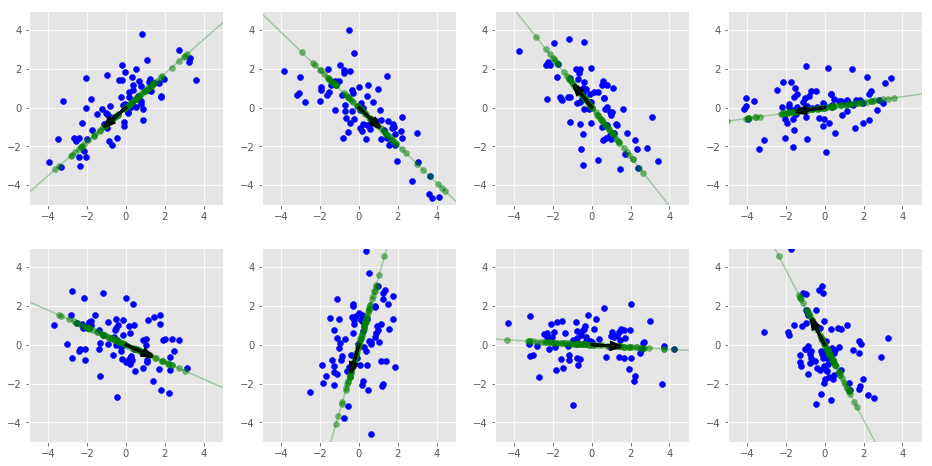

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_1dim_pca(ax)

In these plots, we superimpose the first principal component onto a random scatter plot.  Notice that:

> The green line is chosen so that the projections of the data points onto this line are **maximally spread out**.

The direction of this line is called the **first principal component** of the data.

#### General Principal Components

**In general** PCA applied to a dataset $X$ returns the best line, plane, 3-space, 4-space, ... so that when $X$ is projected into the subspace

  - The total squared distance from the original data to the projections in minimized.
  - The total variance (i.e. the sum of the variances along the principal components) of the projected dataset is maximal.

In [8]:
def plot_2dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component lines through the orgin (green).
        - The eigenvectors representing the principal components (black).
        - The point cloud projected onto the principal component lines (green).
    """
    X = random_data_set()
    pcd = PCA(2).fit(X)
    e_1 = pcd.components_[0]
    e_2 = pcd.components_[1]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1], color='b')
    # Plot a lines for the principal components.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e_1[0]*x, e_1[1]*x, color='green', alpha=0.3, linestyle='-')
    ax.plot(e_2[0]*x, e_2[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the first line.
    X_proj = np.dot(X, e_1)
    X_reconst = np.array([t*e_1 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot the projections of the data points onto the second line.
    X_proj = np.dot(X, e_2)
    X_reconst = np.array([t*e_2 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e_1[0], e_1[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.arrow(0, 0, e_2[0], e_2[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


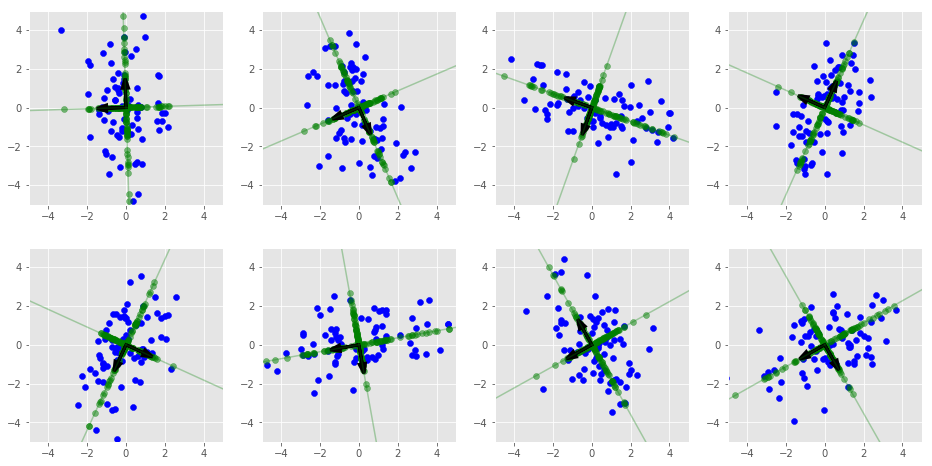

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_2dim_pca(ax)

In these plots, we superimpose the first and second principal components onto a random scatter plot.  Notice that:

  - The **first principal component** determines a green line that maximizes the variance of the data's projection.
  - The **second principal component** is orthogonal to the first, and maximizes the projection of the "leftover" data.

### Computing Principal Components

The solution to the problem of finding principal components involves, somewhat surprisingly, the *eigenvalues* and *eigenvectors* of the covariance matrix $X^T X$ of $X$.

**Note:** X must be centered before computing the covariance in this manner.

#### Setup:

$X$ is a dataset, which we represent as a $n \times p$ matrix of numbers.

In [31]:
np.random.seed(1)
X = random_data_set(n=50)
X[:5, :]

array([[ 1.11009794,  0.32211679],
       [-0.85597849, -2.39150426],
       [-0.28447536, -2.71572745],
       [ 2.18943918,  0.48995701],
       [ 1.46343457, -2.19743105]])

In [32]:
np.cov( X.T)

array([[1.44973615, 0.84385602],
       [0.84385602, 2.39264599]])

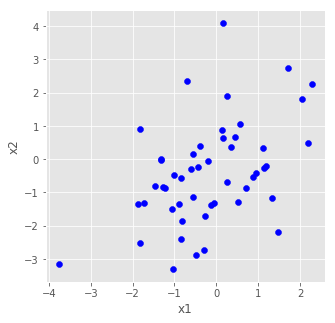

In [33]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1], color='b')
ax.set_xlabel('x1')
ax.set_ylabel('x2');

#### Step 1: Center the Matrix.

**Centering** the matrix is the process of subracting the column means from the columns themselves.  This results in a new matrix with column means zero.

In [34]:
np.mean(X, axis=0)

array([-0.18111798, -0.4125268 ])

In [35]:
X_centered = X - np.mean(X, axis=0)
print(np.mean(X_centered, axis=0))

[ 6.66133815e-18 -5.77315973e-17]


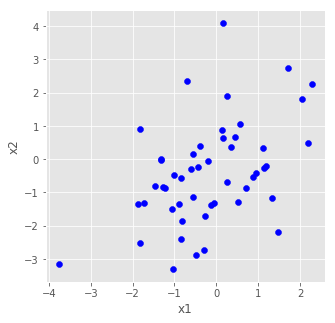

In [36]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1], color='b')
ax.set_xlabel('x1')
ax.set_ylabel('x2');

#### Step 2: Compute the sample covariance matrix.

The sample covariance matrix is $M = \frac{1}{n} X^t X$.

In [37]:
M = np.dot(X.T, X) * (1/float(X.shape[0]))
M

array([[1.45354516, 0.90169493],
       [0.90169493, 2.51497143]])

#### Step 3: Compute the Eigenvectors and Eigenvalues of M

The eigenvectors, when ordered in order of decreasing eigenvalue, are the principal components of $X$.

**Note:**
  - Since $M$ is a symmetric, it has a full set of $p$ eigenvectors.
  - Since $M$ is non-negative definite,  the eigenvalues are non-negative numbers.

In [38]:
e_values, e_vectors = eig(M)
print("The eigenvectors of M are:")
print(e_vectors)
print("The eigenvalues of M are {}".format(e_values))

The eigenvectors of M are:
[[-0.86811181 -0.4963687 ]
 [ 0.4963687  -0.86811181]]
The eigenvalues of M are [0.93797431 3.03054228]


### Intermission: Eigenvectors

Recall that the **eigenvectors** of $M$ are vectors $v$ that satisfy a relationship like:

$$ M v = \lambda v $$

I.e., the matrix $M$ acts as a **scaling** on the vector $v$.

In [39]:
# this is an eigenvector
e_vectors[:, 0]

array([-0.86811181,  0.4963687 ])

In [40]:
# if you transform the eigvec by its matrix...
np.dot(M, e_vectors[:, 0]) 

array([-0.81426657,  0.46558109])

In [41]:
# it's just scaled...
np.dot(M, e_vectors[:, 0]) / e_vectors[:, 0]

array([0.93797431, 0.93797431])

In [43]:
# and the scaling factor is the eigvalue
e_values[0]

0.9379743094427435

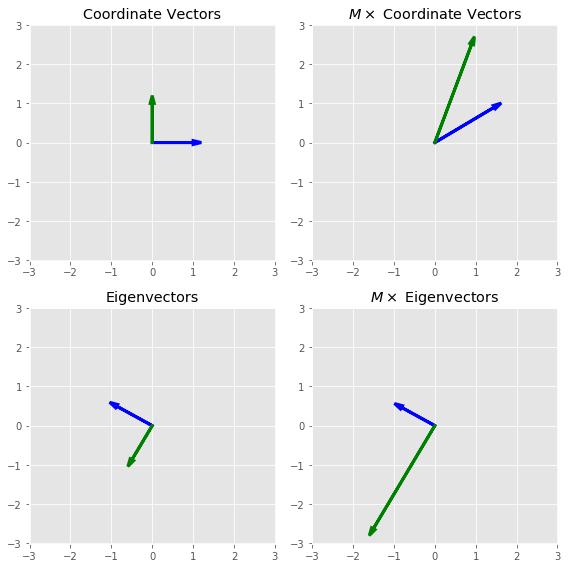

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

coord_vectors = np.array([[1, 0], [0, 1]])
coord_image = np.dot(M, coord_vectors)
e_image = np.dot(M, e_vectors)

# Set coordinate ranges to the maximal possible arrow position
max_coord = max(np.max(coord_vectors), np.max(coord_image), np.max(e_image))
for ax in axs.flatten():
    ax.set_xlim(-max_coord - 0.5, max_coord + 0.5)
    ax.set_ylim(-max_coord - 0.5, max_coord + 0.5)

# Plot the coordinate vectors and their images.
axs[0, 0].arrow(0, 0, coord_vectors[0, 0],  coord_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 0].arrow(0, 0, coord_vectors[0, 1], coord_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 0].set_title("Coordinate Vectors")
axs[0, 1].arrow(0, 0, coord_image[0, 0],  coord_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 1].arrow(0, 0, coord_image[0, 1], coord_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 1].set_title("$M \\times$ Coordinate Vectors")


# Plot the eigenvectors and their images.
axs[1, 0].arrow(0, 0, e_vectors[0, 0],  e_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 0].arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 0].set_title("Eigenvectors")
axs[1, 1].arrow(0, 0, e_image[0, 0],  e_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 1].arrow(0, 0, e_image[0, 1], e_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 1].set_title("$M \\times$ Eigenvectors")

plt.tight_layout()

Above, we see that the effect of multiplying the matrix $M$ by coordinate vectors is difficult to understand, the coordinate vectors are rotated and scaled, each by a different amount.

On the other hand, the eigenvectors of $M$ are much better behaved when multiplied by $M$, the directon of the eigenvectors are preserved, but they are streched or shrunk.

Let's plot the eigenvectors of $M$ on top of the centered data set to see how they relate to the scatterplot of the data

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


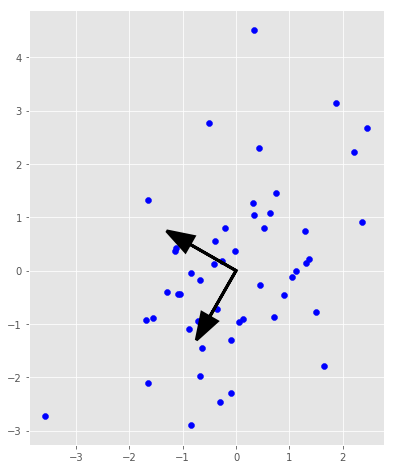

In [48]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(X_centered[:, 0], X_centered[:, 1], color='b')
ax.arrow(0, 0, e_vectors[0, 0], e_vectors[1, 0],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
ax.arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
_ = ax.set(adjustable='box-forced', aspect='equal')

### How we just derived PCA

We found the set of eigenvectors $\{\vec{e_i}\}$ of the covariance matrix $M = \frac{1}{n}X^T X$

These satisfy the equation $M \vec{e_i} = \lambda_i \vec{e_i}$, where $\lambda_i$ is the variance along the direction defined by $\vec{e_i}$

Concatenating all these eigenvectors into a matrix $E$ gives us the matrix representing a rotation in feature space.

$X$ in our new coordinates is $X' = XE^T$

Our covariance matrix in these new coordinates is 

$M' = \frac{1}{n}X'^T X' = \frac{1}{n}(XE^T)^T(XE^T) = \frac{1}{n}EX^TXE^T = EME^T$ 

$M' = 
\begin{bmatrix}
\lambda_1 	& 0 	 & \cdots 	  & 0 	\\
0 	& \lambda_2 	 & \cdots 	  & 0 	\\
\vdots 	& \vdots 	 & \ddots & 0 	\\
0 	& 0 & 0 	  & \lambda_p	
\end{bmatrix}
$




### Summary:

  - The Principal Components algorithm computes the *eigenvectors* and *eigenvalues* of the covariance matrix $X^t X$.
  - Each eigenvector is called a *principal component* of $X$ and represents a direction in feature space.
  - Each eigenvalue is the _amount of variance_ along its corresponding eigenvector.
  - The matrix of eigenvectors $E$ represents a _rotation matrix_ from the original feature axes into the principal component axes.
  - Projecting onto the first $k$ principal components creates the **best k dimensional reconstruction of the data**.

## PCA In Practice

In practice, we use `sklearn.decomposition.PCA` to find principal components.

In [49]:
pcd = PCA(2).fit(X)

Sklearn returns a `PCA` returns an object with a `components_` attribute.

In [50]:
pcd.components_

array([[-0.50609618, -0.86247705],
       [ 0.86247705, -0.50609618]])

The `components_` attribute is an orthogonal matrix containing (as rows) the eigenvectors of the correlation matrix.  That is, the *principal components*.

Let's call the matrix of principal components $E$.

### Properties of Principal Components

1. Taking the first $k$ rows of $E$ gives (a basis for) the "best" $k$ dimensional subspace.  We call this subset matrix $E_{k\times p}$.

2. "Best" above means: projecting the dataset onto this subspace preserves the **most variance in the data** out of all possible such projections.

3. The matrix multiplication $XE_{k\times p}^T$ gives the *coefficients* of the "best" reconstruction of $X$ in the basis $E_k$.

4. The matrix multiplication $(X E_{k\times p}^T) E_{k \times p}$ gives the "best" reconstruction of $X$ as a $k$ dimensional object.  That is, this reconstructs $X$ as a matrix with $k$ columns.

Additionally, the `explained_variance_` attribute contains the total variance of the *projected* dataset.

Each of the numbers in `explained_variance_` is an *eigenvalue* of the covariance matrix $X^t X$.

5. The **eigenvalues** of the covaraince matrix measure the varaince of the projection of the data onto the associated eigenvector (principal component).

### What Principal Component Analysis IS For

**the purpose of PCA is to approximately reconstruct data sets as a lower dimensional object.**

Applications of this include:

  - Visualization.
  - Clustering.
  - Data Compression.


### Example: The Best Scatterplot of Iris

Let's construct a "best" scatterplot of the iris dataset using PCA to project

```
Four dimensional iris data => Best two dimensional reconstruction
                           => Best two dimensional scatterplot
```

In terms of the above discussion we are plotting the *expression of $X$ in the principal componenet basis*.

$$ X E_2^t $$

In [104]:
feat_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

iris = load_iris()
iris_data = pd.DataFrame(iris.data, columns=feat_names)
iris_type = iris.target
iris_data.head()

X = iris_data.values - iris_data.values.mean(axis=0)
pcd = PCA().fit(X)
iris_reduced = np.dot(X, pcd.components_.T)

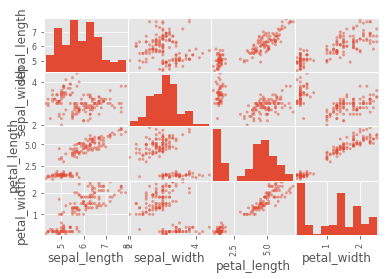

In [105]:
pd.plotting.scatter_matrix(iris_data);

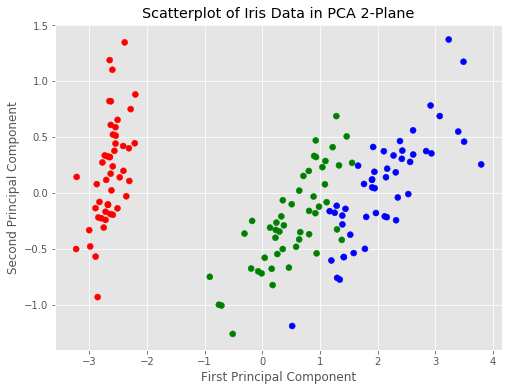

In [106]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(iris_reduced[:, 0], iris_reduced[:, 1], 
           color=np.array(["red", "green", "blue"])[iris_type])
ax.set_title("Scatterplot of Iris Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component");

In [107]:
feat_space_transformed = pcd.transform([[1,0,0,0],
               [0,1,0,0],
               [0,0,1,0],
               [0,0,0,1]])
feat_space_transformed

array([[ 0.36158968,  0.65653988, -0.58099728,  0.31725455],
       [-0.08226889,  0.72971237,  0.59641809, -0.32409435],
       [ 0.85657211, -0.1757674 ,  0.07252408, -0.47971899],
       [ 0.35884393, -0.07470647,  0.54906091,  0.75112056]])

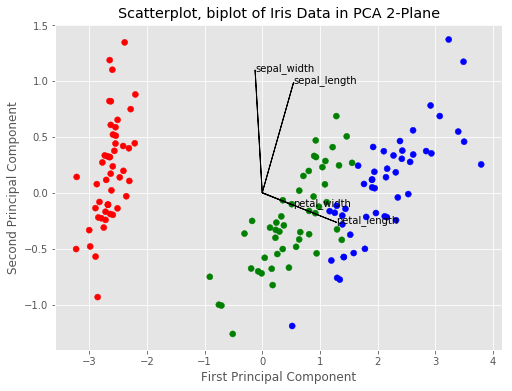

In [111]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(iris_reduced[:, 0], iris_reduced[:, 1], 
           color=np.array(["red", "green", "blue"])[iris_type])
ax.set_title("Scatterplot, biplot of Iris Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component");

for i in range(4):
    ax.arrow(0,0,1.5*feat_space_transformed[i][0],1.5*feat_space_transformed[i][1], lw=1, color="black")
    ax.text(1.5*feat_space_transformed[i][0],1.5*feat_space_transformed[i][1], feat_names[i])

### Example: Eigenfaces: Reconstructing Faces.

As an example of *very* high dimensional data, we introduce the `faces` data set.

An extended version of this example is available in the sklearn docs here: http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [54]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=154)
faces = dataset.data

n_samples, n_features = faces.shape

# Global centering
faces_centered = faces - faces.mean(axis=0)

# Local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [55]:
faces.shape

(400, 4096)

In [56]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

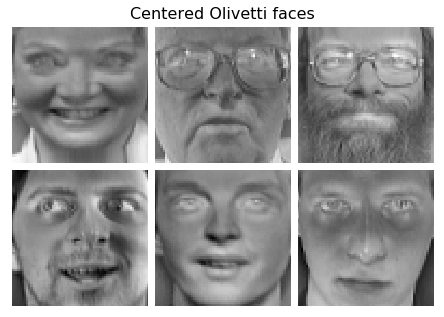

In [57]:
plot_gallery("Centered Olivetti faces", faces_centered[:n_components])

Each of these images is stored as a numpy array.

Each entry in the array measures *one* pixel intensity.

[[-0.05288465 -0.07872145 -0.09184127 ... -0.07057048  0.0761445
   0.11743565]
 [-0.03018858 -0.04831843 -0.0698887  ... -0.06516771  0.05821054
   0.10930555]
 [-0.03242992 -0.08290516 -0.05704789 ... -0.07283308  0.0611238
   0.10700177]
 ...
 [ 0.54305553  0.53032815  0.52888185 ...  0.46428466  0.43686754
   0.41230136]
 [ 0.5304936   0.52165043  0.5205554  ...  0.46218783  0.4446876
   0.4059273 ]
 [ 0.5239751   0.5176527   0.51337576 ...  0.4555865   0.44682604
   0.40869588]]


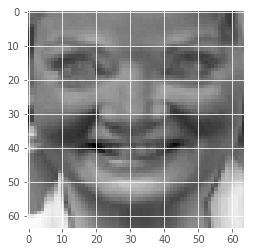

In [58]:
first_face = faces_centered[0].reshape(image_shape)
print(first_face)
plt.imshow(first_face, cmap=cm.gray);

Each image is a $64 \times 64$ array, and so is represented as a $4096$ dimensional object.

Let's apply PCA to the faces dataset to lower the dimensionality.

In [59]:
faces_pcd = PCA(100).fit(faces_centered)

The columns in the $E^t$ matrix (i.e. `faces_pcd.components_.T`) are called **eigenfaces**.

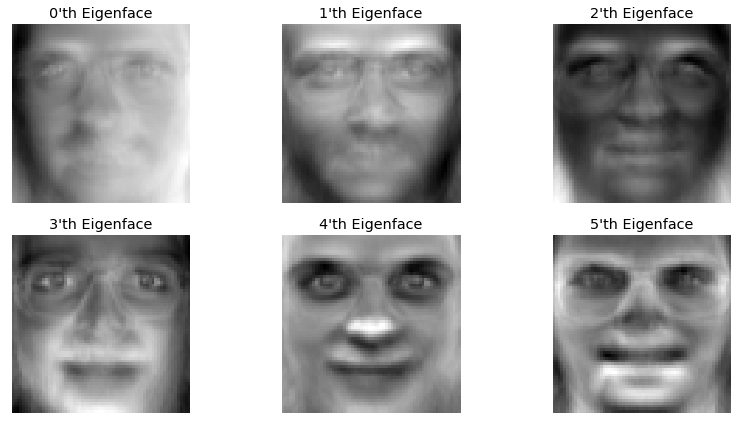

In [60]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, i in zip(axs.flatten(), range(6)):
    eigenface = faces_pcd.components_[i, :].reshape(image_shape)
    ax.imshow(eigenface, cmap=cm.gray)
    ax.set_title("{}'th Eigenface".format(i))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Question:** What facial features seem to be captured in the first few eigenfaces?  Why do you think this may be so?

Let's do our reconstruction procedure with the face data.  This lets us create **smaller dimensional faces**.

In [61]:
def reduce_face_data(n_dim):
    eigenvalues = faces_pcd.components_[:n_dim, :].T
    faces_reduced = np.dot(np.dot(faces_centered, eigenvalues), eigenvalues.T)
    return faces_reduced

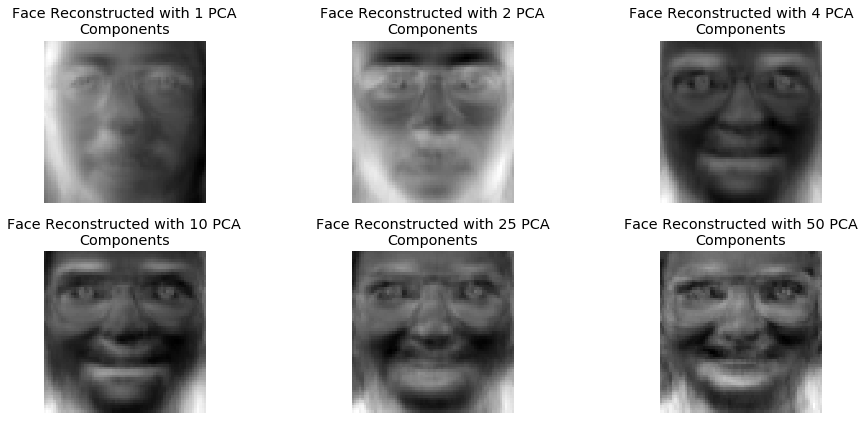

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))

for ax, dim in zip(axs.flatten(), [1, 2, 4, 10, 25, 50]):
    reduced_data = reduce_face_data(dim)
    first_face = reduced_data[0].reshape(image_shape)
    ax.imshow(first_face, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} PCA\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Discussion:** When applying PCA to reduce the dimensionality of a data set, we have to choose a *number of dimensions* to keep.  What kind of concerns should we consider when choosing this number?

### What Principal Component Analysis is NOT For

There is an unfortunately popular method which combines PCA with regression, with the intent of improving the generalization properties of the regression.  It is called **Principal Component Regression** and it goes like this:

**Setup**: You have a matrix $X$ and a response $y$, and you want to fit a regression to predict $y$ from $X$.

**Procedure**:
1. Do PCA on $X$, let $E$ be the matrix of principal components.
2. Discard some of the principal components, get the matrix $E_{k\times p}$.
3. Regress $y$ on $E_{k\times p}$.

**Discussion:** Critique this procedure, pros and cons.

For details on why **not** to use selection of principal components as a regularization strategy in regression [see this paper](http://www.uvm.edu/~rsingle/stat380/F04/possible/Hadi%2BLing-AmStat-1998_PCRegression.pdf) and [this paper](http://automatica.dei.unipd.it/public/Schenato/PSC/2010_2011/gruppo4-Building_termo_identification/IdentificazioneTermodinamica20072008/Biblio/Articoli/PCR%20vecchio%2082.pdf).

See also [this example](https://gist.github.com/lemonlaug/976543b650e53db24ab2) from our own Isaac Laughlin

[This question](http://stats.stackexchange.com/questions/101485/examples-of-pca-where-pcs-with-low-variance-are-useful) gives real life examples of data sets where PCR fails because $y$ is only related to the **low variance** principal components.

Still, PCR gets used (abused?) and comes up in interview questions: http://stats.stackexchange.com/questions/239518/logistic-regression-with-lasso-versus-pca